In [12]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime


#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Import of full_df 



In [13]:
full_df = pd.read_pickle('../data/processed/full_df.pkl')
full_df.head()
full_df.shape

(11414, 47)

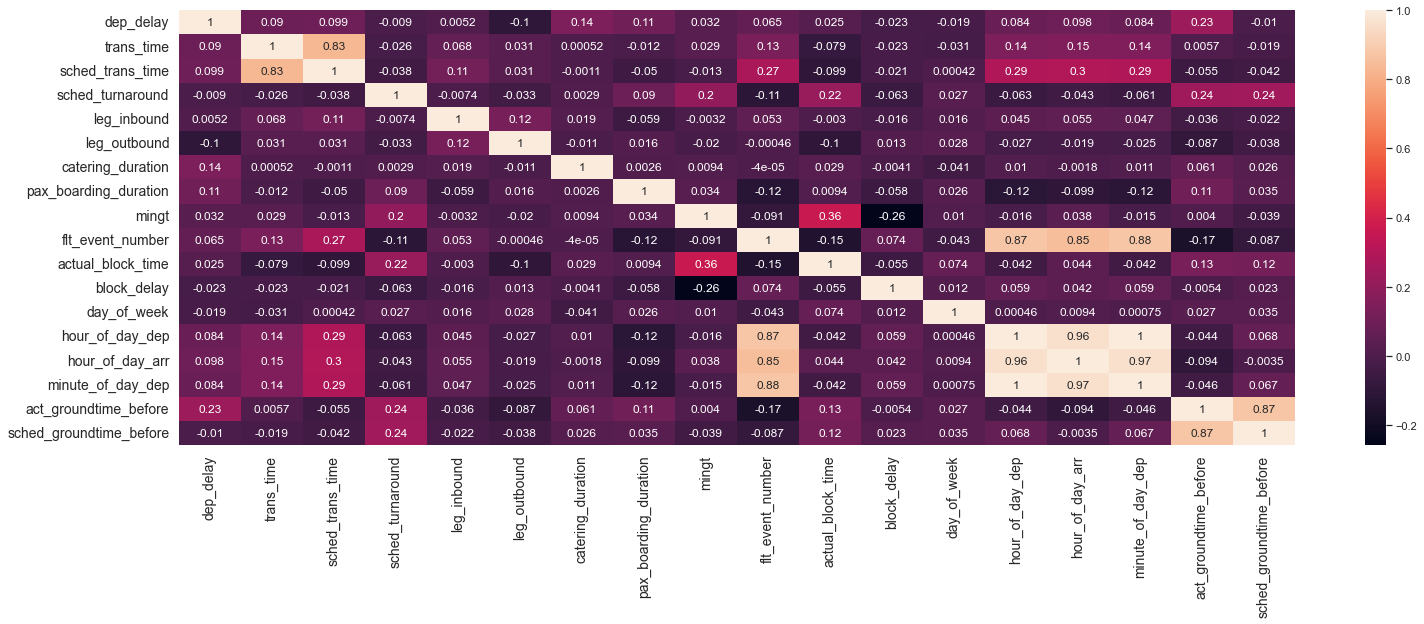

In [14]:
# Correlation Matrix
sns.set(rc={'figure.figsize':(25, 8)})
correlations = full_df.drop(['rows_to_drop', 'rows_to_drop_grounddelay', 'rot_mismatch', 'cleaning_duration', 'leg_no', 'ground_delay'], axis=1).corr()
sns.heatmap(correlations, annot=True)
plt.tick_params(axis='both', which='major', labelsize=14)

In [15]:
# Getting the correlations for block delay ordered by absolute magnitude
corr_block_delay = correlations['block_delay'].reindex(correlations['block_delay'].abs().sort_values(ascending=False).index)
corr_block_delay = corr_block_delay[1:] # filter out block delay itself
corr_block_delay

mingt                     -0.258721
flt_event_number           0.073723
sched_turnaround          -0.062594
hour_of_day_dep            0.058946
minute_of_day_dep          0.058631
pax_boarding_duration     -0.057829
actual_block_time         -0.054573
hour_of_day_arr            0.042377
sched_groundtime_before    0.023233
dep_delay                 -0.023224
trans_time                -0.022671
sched_trans_time          -0.020506
leg_inbound               -0.016264
leg_outbound               0.013388
day_of_week                0.012405
act_groundtime_before     -0.005395
catering_duration         -0.004104
Name: block_delay, dtype: float64

c:\Users\Paul\.conda\envs\py310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


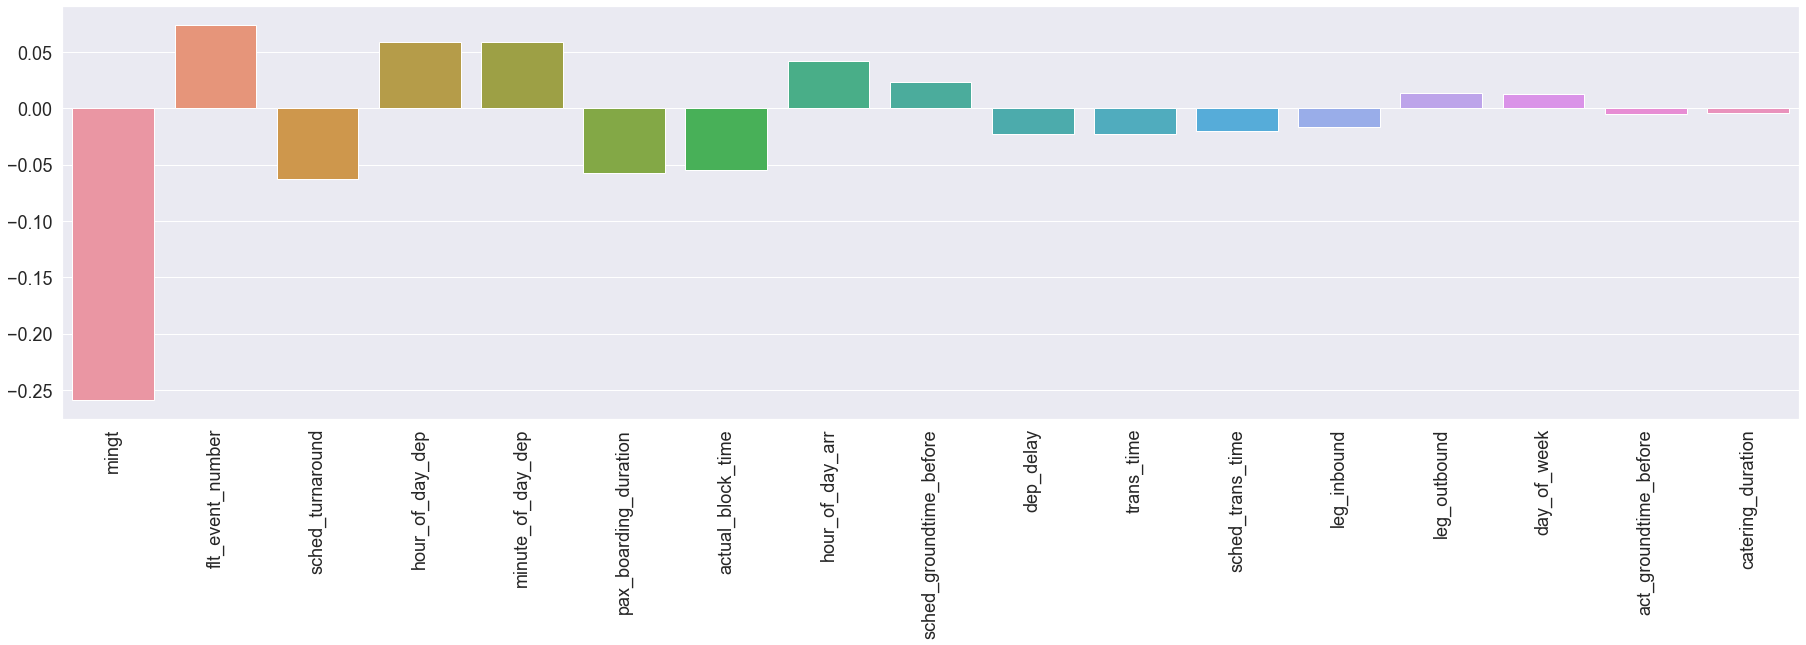

In [16]:
#plt.plot(corr_block_delay)
sns.barplot(corr_block_delay.index, corr_block_delay.values)
plt.xticks(rotation=90)
plt.tight_layout()

plt.tick_params(axis='both', which='major', labelsize=18)

Hypothesis: Time of day has influence on dep delay - not visible in the scatter plot

<AxesSubplot:xlabel='Min_of_Day', ylabel='block_delay'>

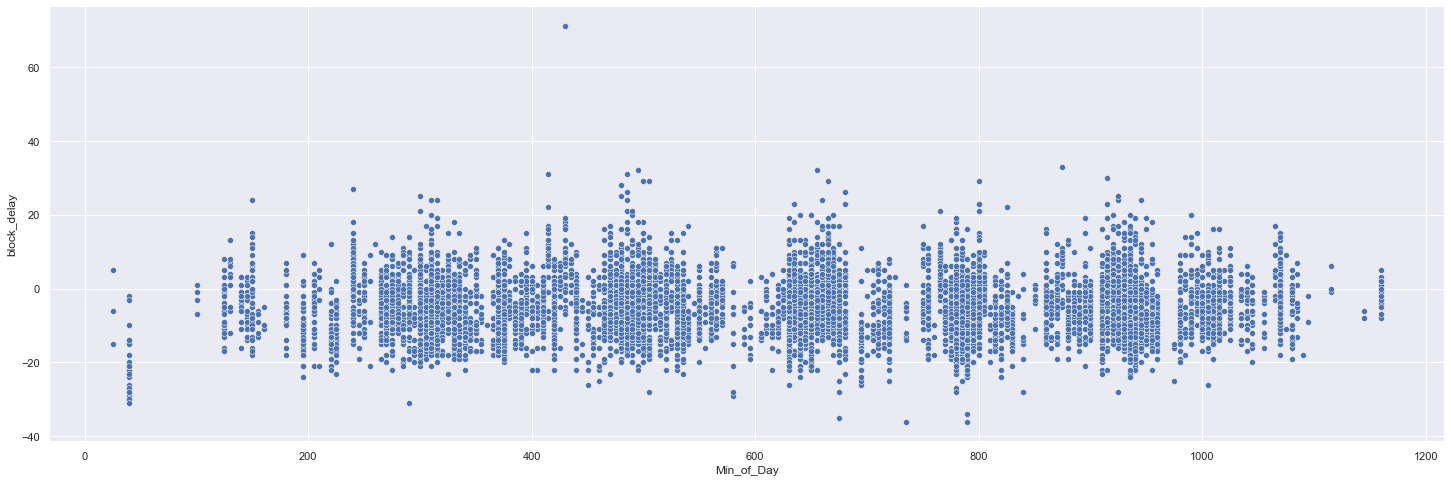

In [17]:
temp = full_df[full_df['rows_to_drop_grounddelay']==0][['dep_sched_time', 'block_delay']]

temp['Min_of_Day'] = temp['dep_sched_time'].dt.hour*60 + temp['dep_sched_time'].dt.minute


sns.set(rc={'figure.figsize':(25, 8)})
sns.scatterplot(x=temp['Min_of_Day'], y=temp['block_delay'])


<AxesSubplot:>

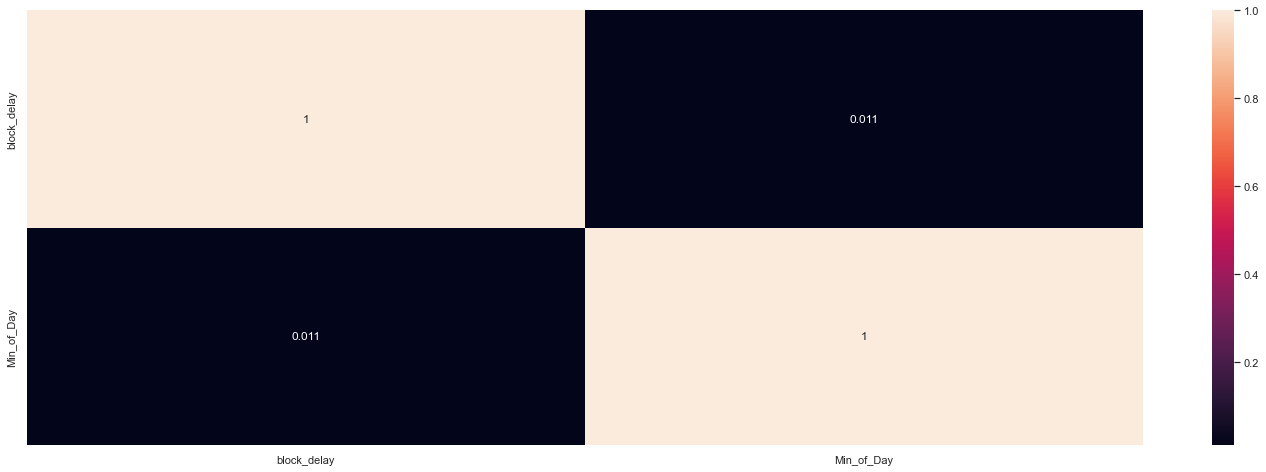

In [18]:
sns.heatmap(temp.corr(), annot = True)

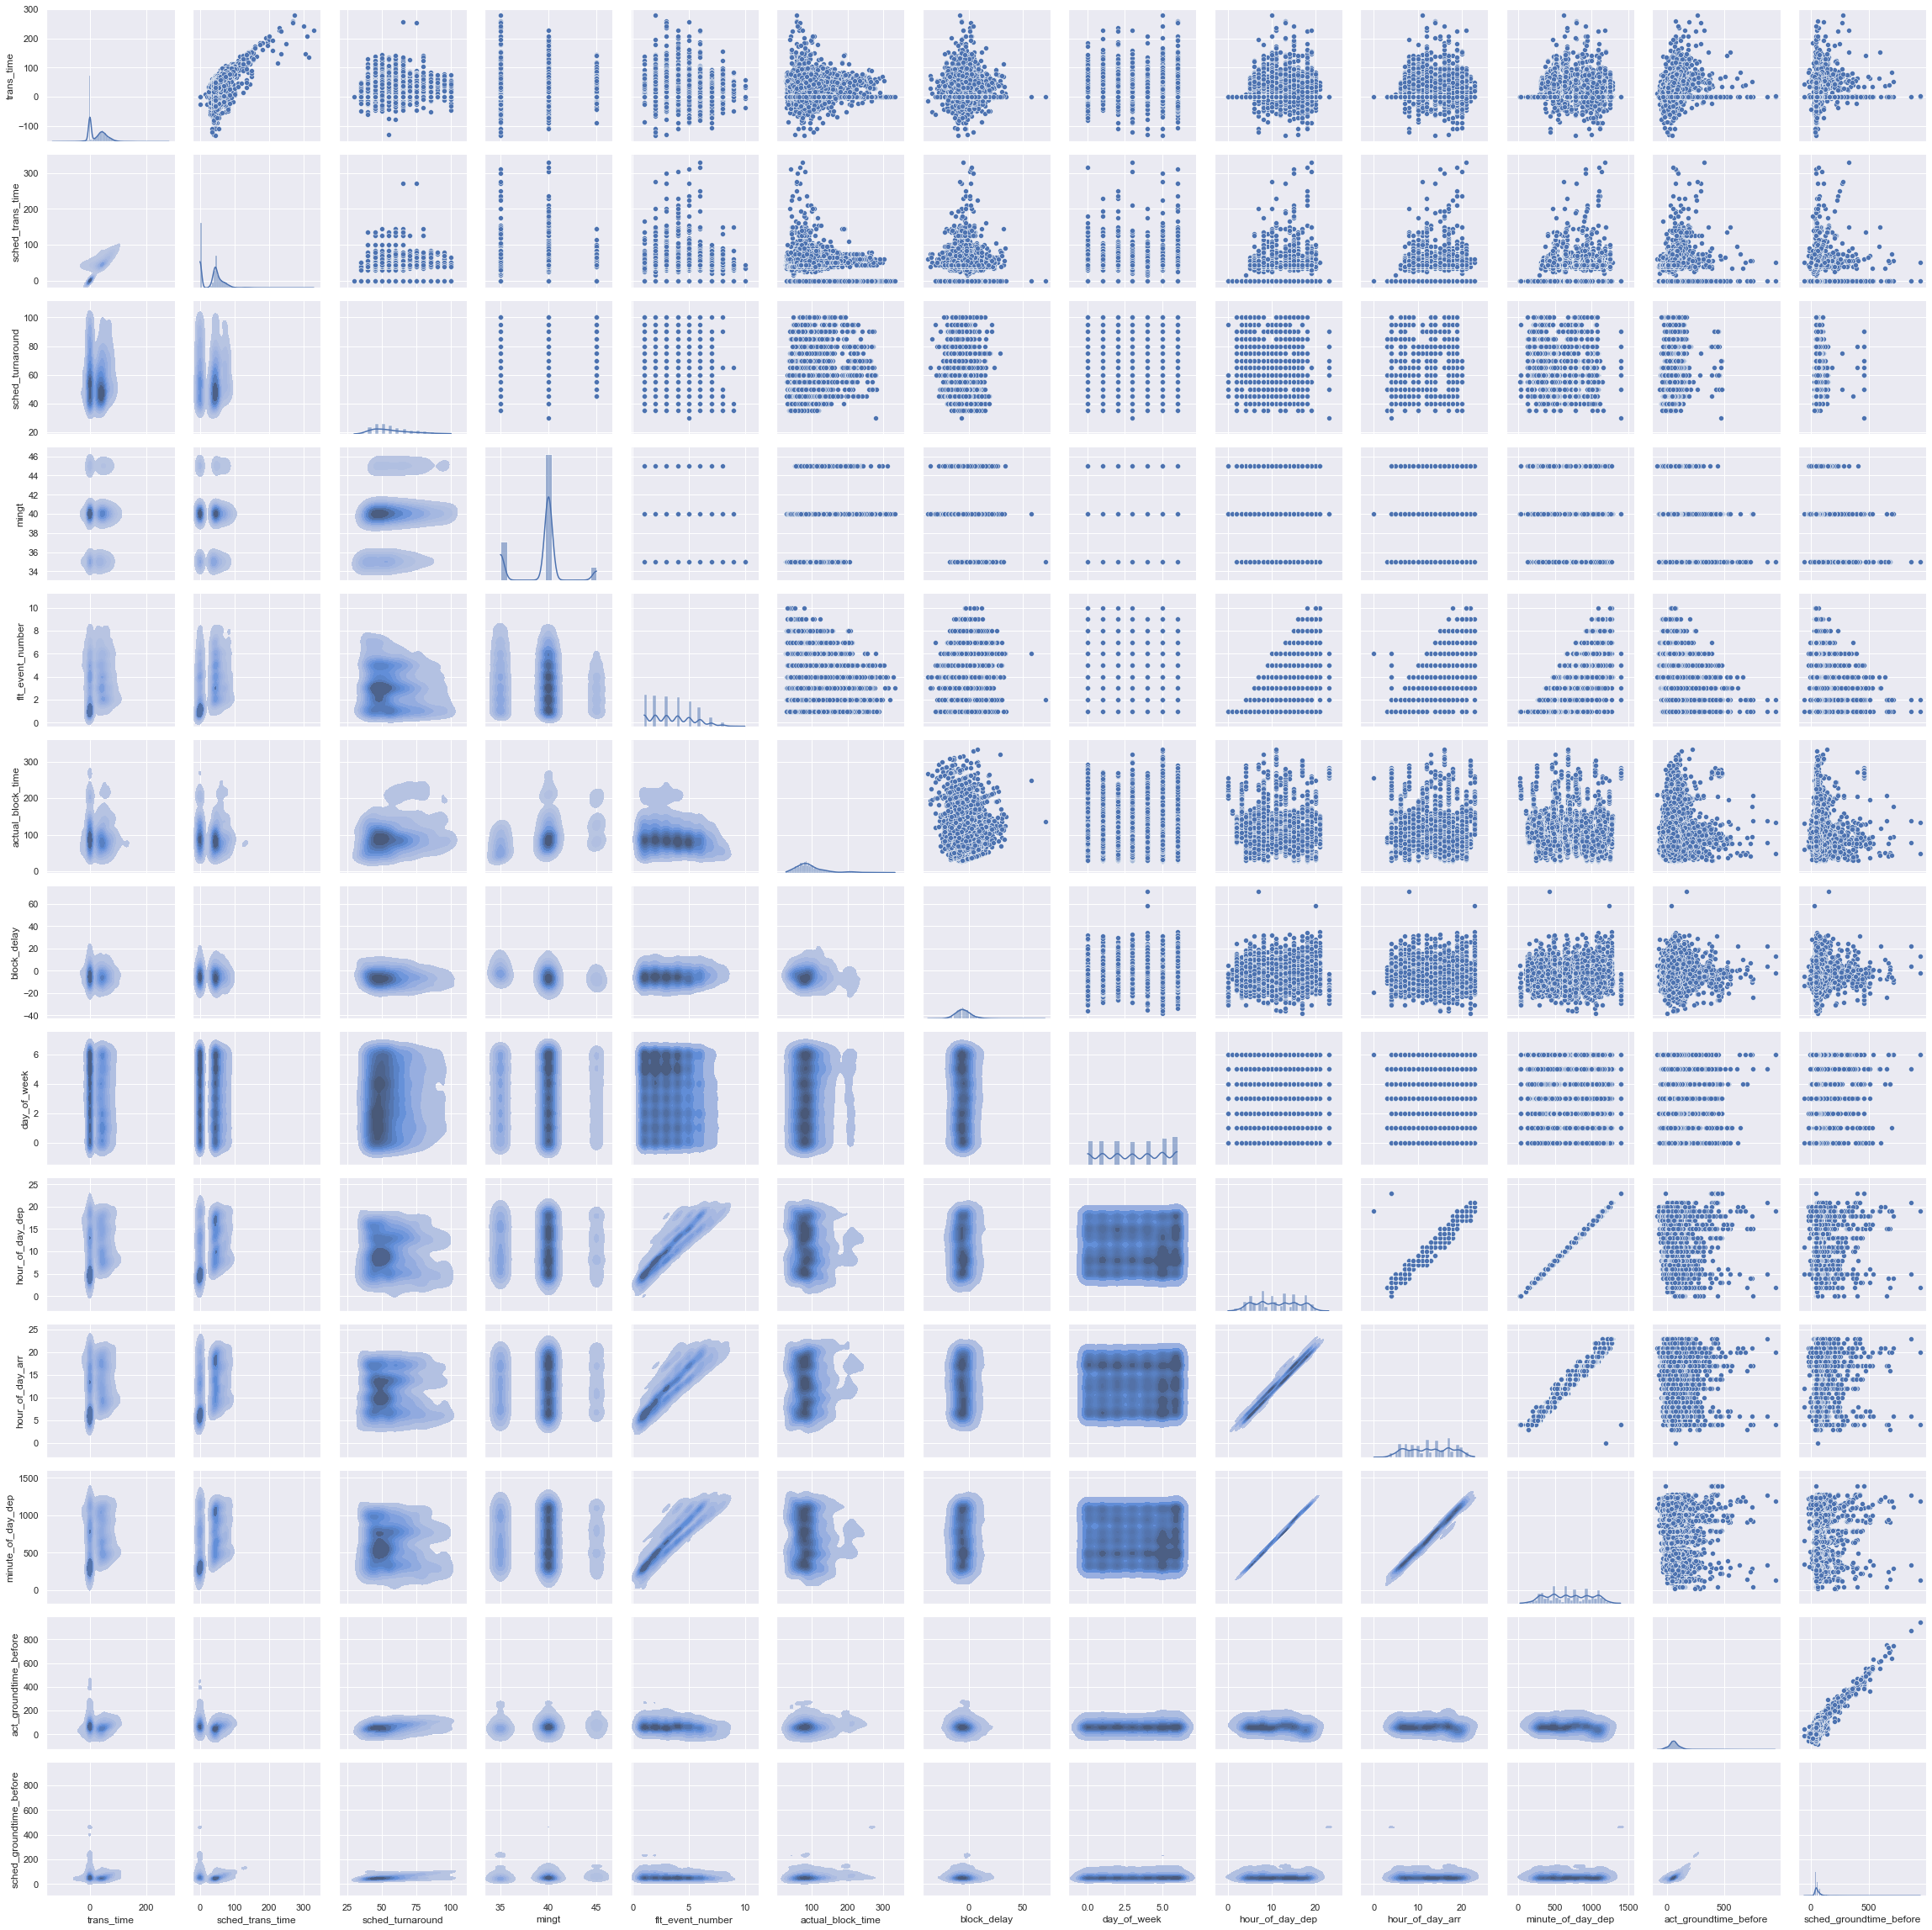

In [19]:
# Pairplot

pairplot_data = full_df.drop(['rows_to_drop', 'rows_to_drop_grounddelay', 'rot_mismatch', 'cleaning_duration', 'leg_no', 'ground_delay', 'dep_delay', 'leg_inbound', 'leg_outbound', 'catering_duration', 'pax_boarding_duration'], axis=1)
plot = sns.PairGrid(pairplot_data)
plot.map_upper(sns.scatterplot)
plot.map_lower(sns.kdeplot, fill=True)
plot.map_diag(sns.histplot, kde=True)

# Hub Analysis 

As East Carmen is a Hub carrier, we have many flights at the same time. If we encode the hub congestion into our data, we might improve the forecast. This is done here, using gaussians of single flights and their density as an approximation. 

In [20]:
# Get hub flights
temp = full_df[full_df['arr_leg_inbound']!='East Carmen']
temp

,leg_no,fn_carrier,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,day_of_origin,fn_number_y,ac_registration_y,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,mingt,flt_event_number,leg,rot_mismatch,actual_block_time,block_delay,ground_delay,day_of_week,hour_of_day_dep,hour_of_day_arr,minute_of_day_dep,Crewchange,act_groundtime_before,sched_groundtime_before,Crewchange_before,rows_to_drop,rows_to_drop_grounddelay
1,272022230,East Carmen Airlines,2019-06-01,2019-06-01 08:20:00,2019-06-01,2019-06-01 10:35:00,2019-06-01 08:35:00,2019-06-01 10:41:00,ECLBAX,other problem,15.0,321,60,60,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,45.0,2,East Carmen-South Nathaniel,False,126.0,-9.0,15.0,5,8,10,500,no change,94.0,95.0,both,0,0
3,271997824,East Carmen Airlines,2019-06-01,2019-06-01 15:35:00,2019-06-01,2019-06-01 17:00:00,2019-06-01 16:18:00,2019-06-01 17:32:00,ECLBAX,rotational problem,43.0,321,64,70,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,45.0,4,East Carmen-Joneshaven,False,74.0,-11.0,43.0,5,15,17,935,no change,86.0,80.0,both,0,0
4,271998033,East Carmen Airlines,2019-06-01,2019-06-01 17:50:00,2019-06-01,2019-06-01 19:10:00,2019-06-01 18:04:00,2019-06-01 19:14:00,ECLBAX,other problem,14.0,321,42,50,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,45.0,5,Joneshaven-East Carmen,False,70.0,-10.0,14.0,5,17,19,1070,last flt of day,32.0,50.0,no change,0,1
5,272337586,East Carmen Airlines,2019-06-02,2019-06-02 06:50:00,2019-06-02,2019-06-02 08:10:00,2019-06-02 07:10:00,2019-06-02 08:32:00,ECLBAX,other problem,20.0,321,73,45,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,45.0,1,East Carmen-Joneshaven,False,82.0,2.0,20.0,6,6,8,410,no change,38.0,45.0,first flt of day,0,0
7,272014566,East Carmen Airlines,2019-06-02,2019-06-02 11:10:00,2019-06-02,2019-06-02 12:25:00,2019-06-02 11:33:00,2019-06-02 12:33:00,ECLBAX,other problem,23.0,321,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,45.0,3,East Carmen-Marioborough,False,60.0,-15.0,23.0,6,11,12,670,no change,65.0,50.0,both,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12096,272211046,East Carmen Airlines,2019-06-30,2019-06-30 10:30:00,2019-06-30,2019-06-30 12:10:00,2019-06-30 10:34:00,2019-06-30 12:05:00,ECLXEX,other problem,4.0,320,37,45,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,40.0,3,Lisamouth-East Carmen,False,91.0,-9.0,4.0,6,10,12,630,both,39.0,45.0,no change,0,0
12097,271969272,East Carmen Airlines,2019-06-30,2019-06-30 13:00:00,2019-06-30,2019-06-30 14:15:00,2019-06-30 13:30:00,2019-06-30 14:36:00,ECLXEX,rotational problem,30.0,320,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,40.0,4,East Carmen-West Jason,False,66.0,-9.0,30.0,6,13,14,780,no change,85.0,50.0,both,0,0
12098,271969452,East Carmen Airlines,2019-06-30,2019-06-30 15:00:00,2019-06-30,2019-06-30 16:20:00,2019-06-30 15:30:00,2019-06-30 16:40:00,ECLXEX,rotational problem,30.0,320,41,45,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,40.0,5,West Jason-East Carmen,False,70.0,-10.0,30.0,6,15,16,900,no change,54.0,45.0,no change,0,0
12099,272187492,East Carmen Airlines,2019-06-30,2019-06-30 17:05:00,2019-06-30,2019-06-30 18:20:00,2019-06-30 17:37:00,2019-06-30 19:01:00,ECLXEX,rotational problem,32.0,320,50,45,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,40.0,6,East Carmen-West Jason,False,84.0,9.0,32.0,6,17,18,1025,no change,57.0,45.0,no change,0,0


<AxesSubplot:xlabel='minute_of_day_dep', ylabel='Density'>

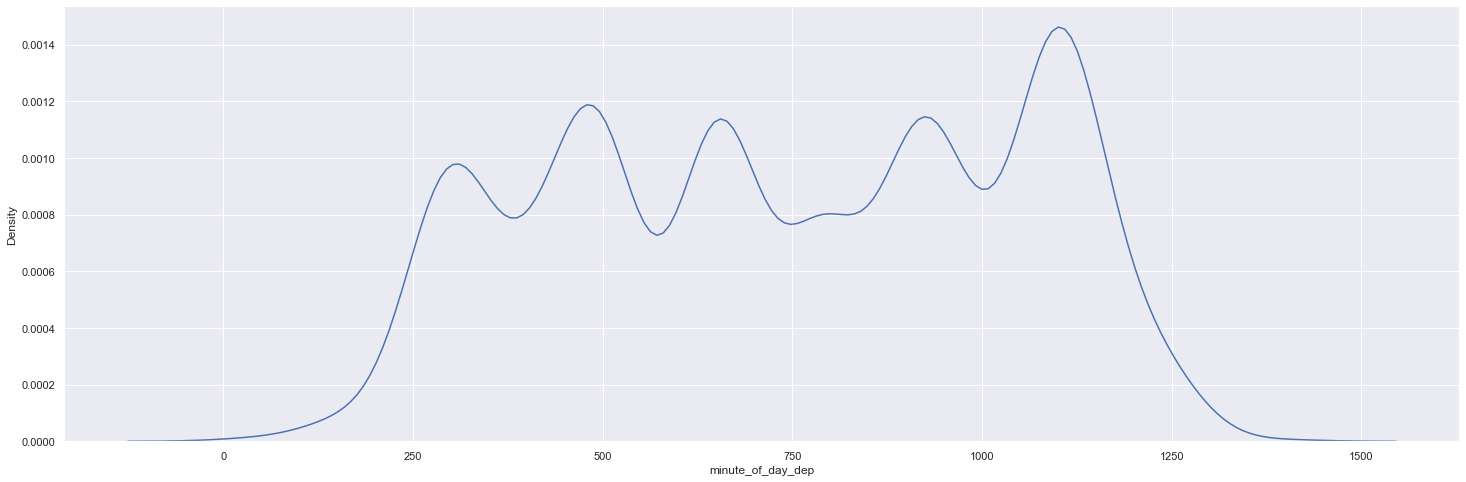

In [21]:
# display hub departure peaks
sns.kdeplot(data=temp['minute_of_day_dep'])

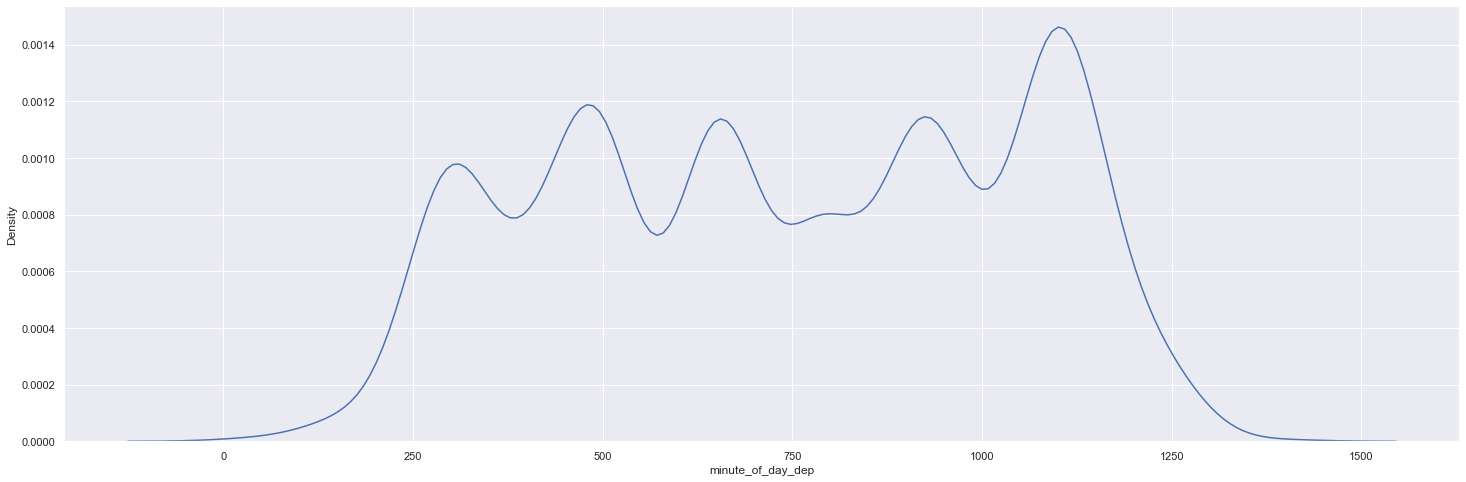

In [22]:
# Get the computed KDE and add it as a feature to the closest minute of day of an observations' departure in full_df

kdes = pd.DataFrame(sns.kdeplot(data=temp['minute_of_day_dep']).lines[0].get_data()).T
kdes.columns=['minute', 'density']
full_df_merged = full_df.merge(kdes, how='cross')

full_df_merged['min_diff']=abs(full_df_merged['minute_of_day_dep']-full_df_merged['minute'])

full_df_merged = full_df_merged.sort_values(by='min_diff').drop_duplicates(subset='leg_no').drop(['minute', 'min_diff'], axis=1)

full_df_merged['density'] = np.where(full_df_merged['arr_leg_inbound']!='East Carmen', full_df_merged['density']*1000, 0)

full_df = full_df_merged
